dataset: davis
cuda_name: cuda:1
GNNNet Loaded
dataset: davis
test entries: 5011 effective test entries 5011
effective drugs,effective prot: 68 442
Make prediction for 5011 samples...
Predicted   0.0  1.0
Actual              
0.0        3474   32
1.0        1149  356


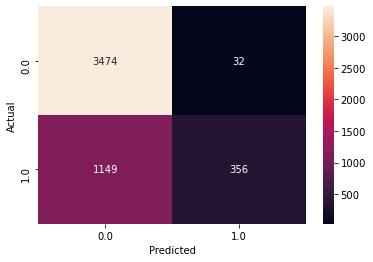

AUC: 0.614


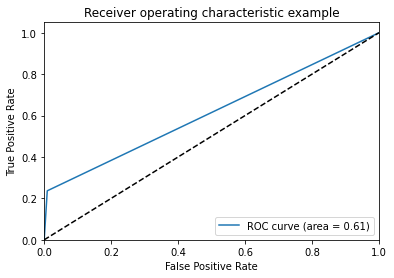

In [84]:
import os
import sys
import torch
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
from torch_geometric.data import Batch

from emetrics import get_aupr, get_cindex, get_rm2, get_ci, get_mse, get_rmse, get_pearson, get_spearman
from utils import *
from scipy import stats
from gnn import GNNNet
from data_process import create_dataset_for_test

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from collections import Counter

def predicting(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data_mol = data[0].to(device)
            data_pro = data[1].to(device)
            # data = data.to(device)
            output = model(data_mol, data_pro)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data_mol.y.view(-1, 1).cpu()), 0)
    return total_labels.numpy().flatten(), total_preds.numpy().flatten()


def load_model(model_path):
    model = torch.load(model_path)
    return model

def c_matrix(Y, P):
    for i in range(len(P)):
        if P[i] >=1:
            P[i] = 1
        else:
            P[i] = 0
    df = pd.DataFrame({'y_Actual':Y,'y_Predicted':P})
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = False)
    print(confusion_matrix)
    sn.heatmap(confusion_matrix, annot=True, fmt='g')
    plt.savefig('davis_class.jpg', dpi=400) 
    plt.show()
    

def auc(Y, P):
    y_true = np.array(Y)
    y_pred = np.array(P)
    # claculate roc curve
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    # calcuate AUC
    auc = roc_auc_score(y_true, y_pred)
    print('AUC: %.3f' %auc)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig('davis_roc.jpg', dpi=400) 
    plt.show()

    
    
def calculate_metrics(Y, P, dataset='davis'):
    # aupr = get_aupr(Y, P)
    cindex = get_cindex(Y, P)  # DeepDTA
    cindex2 = get_ci(Y, P)  # GraphDTA
    rm2 = get_rm2(Y, P)  # DeepDTA
    mse = get_mse(Y, P)
    pearson = get_pearson(Y, P)
    spearman = get_spearman(Y, P)
    rmse = get_rmse(Y, P)

    print('metrics for ', dataset)
    # print('aupr:', aupr)
    print('cindex:', cindex)
    print('cindex2', cindex2)
    print('rm2:', rm2)
    print('mse:', mse)
    print('pearson', pearson)

    result_file_name = 'results/result_' + model_st + '_' + dataset + '.txt'
    result_str = ''
    result_str += dataset + '\r\n'
    result_str += 'rmse:' + str(rmse) + ' ' + ' mse:' + str(mse) + ' ' + ' pearson:' + str(
        pearson) + ' ' + 'spearman:' + str(spearman) + ' ' + 'ci:' + str(cindex) + ' ' + 'rm2:' + str(rm2)
    print(result_str)
    open(result_file_name, 'w').writelines(result_str)


def plot_density(Y, P, fold=0, dataset='davis'):
    plt.figure(figsize=(10, 5))
    plt.grid(linestyle='--')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.scatter(P, Y, color='blue', s=40)
    plt.title('density of ' + dataset, fontsize=30, fontweight='bold')
    plt.xlabel('predicted', fontsize=30, fontweight='bold')
    plt.ylabel('measured', fontsize=30, fontweight='bold')
    # plt.xlim(0, 21)
    # plt.ylim(0, 21)
    if dataset == 'davis':
        plt.plot([5, 11], [5, 11], color='black')
    else:
        plt.plot([6, 16], [6, 16], color='black')
    # plt.legend()
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=12, fontweight='bold')
    plt.savefig(os.path.join('results', dataset + '_' + str(fold) + '.png'), dpi=500, bbox_inches='tight')


if __name__ == '__main__':
    dataset = ['davis', 'kiba'][0]  # dataset selection
    model_st = GNNNet.__name__
    print('dataset:', dataset)

    cuda_name = ['cuda:0', 'cuda:1', 'cuda:2', 'cuda:3'][1]  # gpu selection
    print('cuda_name:', cuda_name)

    TEST_BATCH_SIZE = 512
    models_dir = 'models'
    results_dir = 'results'

    device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
    model_file_name = 'models/model_' + model_st + '_' + dataset + '.model'
    result_file_name = 'results/result_' + model_st + '_' + dataset + '.txt'

    model = GNNNet()
    model.to(device)
    model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))
    test_data = create_dataset_for_test(dataset)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)

    Y, P = predicting(model, device, test_loader)
    # calculate_metrics(Y, P, dataset)  # In Classification model, pass this function
    # plot_density(Y, P, fold, dataset) # In Classification model, pass this function
    c_matrix(Y, P) # In Classification model, Use this function
    auc(Y, P)      # In Classification model, Use this function